# Prepoznavanje oblika

Autor: Djordje Marjanovic 2016/0120

## Zadatak 1

Za bazu rukom pisanih samoglasnika, koja je dostupna na sajtu predmeta*
isprojektovati inovativni sistem za prepoznavanje cifara zasnovan na
testiranju hipoteza. Rezultate prikazati u obliku matrice konfuzije. Izveštaj
treba da sadrži kratki opis isprojektovanog sistema, obrazložen izbor
obeležja, kao i karakteristične primere pravilno i nepravilno klasifikovanih
slova.

### Postavka

In [28]:
%reset -f

import random

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import scipy.stats

dataset_dir = "data/Slova/"
letters = ['A', 'E', 'I', 'O', 'U']
train_set_size_per_letter = 80
test_set_size_per_letter = 20

### Učitavanje podataka

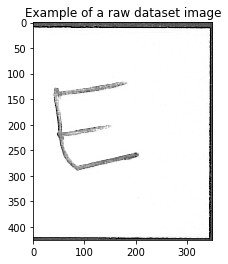

In [29]:
train_set = []
for letter in letters:
    for idx in list(range(1, train_set_size_per_letter + 1)):
        img = cv2.imread("{}baza{}{:03d}.bmp".format(dataset_dir, letter, idx))
        train_set.append((letter, img))
        
test_set = []
for letter in letters:
    indices = range(
        train_set_size_per_letter + 1,
        test_set_size_per_letter + train_set_size_per_letter + 1
    )
    for idx in list(indices):
        img = cv2.imread("{}baza{}{:03d}.bmp".format(dataset_dir, letter, idx))
        test_set.append((letter, img))

random_point_index = random.randint(0, len(train_set))

random_point = train_set[random_point_index]
plt.imshow(random_point[1])
plt.title("Example of a raw dataset image")
plt.show()

### Priprema slika

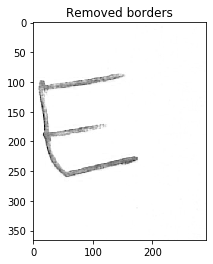

In [30]:
border_size = 30
train_set = [(
    label,
    sample[
        border_size : sample.shape[0] - border_size,
        border_size : sample.shape[1] - border_size
    ][:, :, 0] / 256.0
) for label, sample in train_set]

test_set = [(
    label,
    sample[
        border_size : sample.shape[0] - border_size,
        border_size : sample.shape[1] - border_size
    ][:, :, 0] / 256.0
) for label, sample in test_set]

random_point = train_set[random_point_index]
plt.imshow(random_point[1], cmap = 'gray')
plt.title("Removed borders")
plt.show()

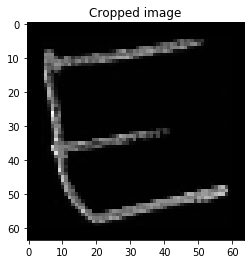

In [31]:
def crop(image: np.ndarray):
    from scipy.ndimage.morphology import binary_erosion, binary_dilation
    binary_threshold = 0.9
    erosion_size = 2
    padding = 4
    final_size = (64, 64)
    
    binary_image = 1.0 * image < binary_threshold
    binary_image = binary_erosion(
        binary_image, 
        structure = np.ones((erosion_size, erosion_size))
    )
    binary_image = binary_dilation(
        binary_image, 
        structure = np.ones((erosion_size, erosion_size))
    )
    
    x, y = np.meshgrid(range(image.shape[1]), range(image.shape[0]))
    x = x * binary_image
    y = y * binary_image
    
    u_bound = max(0, np.min(y[np.nonzero(y)]) - erosion_size)
    b_bound = min(image.shape[0] - 1, y.max() + erosion_size + 1)
    l_bound = max(0, np.min(x[np.nonzero(x)]) - erosion_size)
    r_bound = min(image.shape[1] - 1, x.max() + erosion_size + 1)
    
    cropped_image = image[u_bound: b_bound, l_bound: r_bound]
    resized_image = cv2.resize(
        src = cropped_image,
        dsize = (final_size[1] - 2 * padding, final_size[0] - 2 * padding)
    )
    
    final_image = np.ones(final_size)
    final_image[
        padding: final_size[0] - padding,
        padding: final_size[1] - padding
    ] = resized_image
    
    return 1 - final_image

train_set = [(label, crop(sample)) for label, sample in train_set]
test_set = [(label, crop(sample)) for label, sample in test_set]

random_point = train_set[random_point_index]
plt.imshow(random_point[1], cmap = 'gray')
plt.title("Cropped image")
plt.show()

### Funkcije za vizuelizaciju

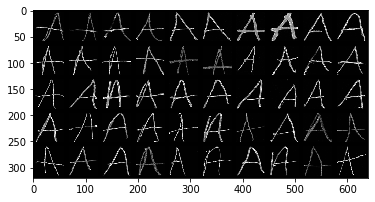

In [40]:
def display_square(imgs: list, n: int, m: int):
    w, h = imgs[0].shape
    comb = np.zeros((h * n, w * m))
    for i in range(n):
        for j in range(m):
            comb[i * h: (i + 1) * h, j * w: (j + 1) * w] =\
                imgs[i * m + j]
    plt.imshow(comb, cmap = 'gray')
    plt.show()

display_square([img for label, img in train_set[:50]], 5, 10)

### Karakteristike

In [33]:
import features

selected_features = [
    features.Stack([
        features.RectSelect(20, 43, 20, 43),
        features.Sum(),
        features.Multiply(1 / (43 - 20)**2)
    ]),
    features.Stack([
        features.RectSelect(0, 63, 0, 20),
        features.Sum(),
        features.Multiply(1 / 64 / 21)
    ]),
    features.Stack([
        features.RectSelect(0, 63, 43, 63),
        features.Sum(),
        features.Multiply(1 / 64 / 21)
    ]),
    features.Stack([
        features.RectSelect(0, 20, 0, 63),
        features.Sum(),
        features.Multiply(1 / 64 / 21)
    ]),
    features.Stack([
        features.RectSelect(43, 63, 0, 63),
        features.Sum(),
        features.Multiply(1 / 64 / 21)
    ])
]

X = np.array([
    [letters.index(letter)] + [
        feature.get_feature(sample)
        for feature in selected_features
    ]
    for letter, sample in train_set
])

X_test = np.array([
    [letters.index(letter)] + [
        feature.get_feature(sample)
        for feature in selected_features
    ]
    for letter, sample in test_set
])

print(selected_features[0].get_feature(random_point[1]))

0.0351618179196805


### Vizuelizacija karakteristika

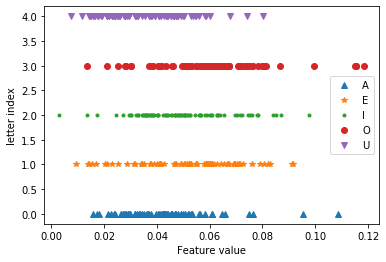

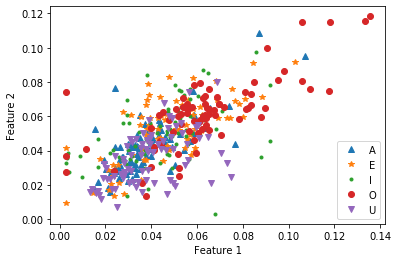

In [41]:
letter_to_symbol = {
    'A': '^',
    'E': '*',
    'I': '.',
    'O': 'o',
    'U': 'v',
}


def feature_distribution(feature_id: int):
    for letter_id in range(len(letters)):
        plt.plot(
            X[X[:, 0] == letter_id][:, feature_id + 1],
            np.ones(train_set_size_per_letter) * letter_id,
            letter_to_symbol[letters[letter_id]]
        )
    plt.legend(letters)
    plt.xlabel('Feature value')
    plt.ylabel('letter index')
    plt.show()


def compare_features(feature1_id: int = 0, feature2_id: int = 1):
    for letter_id in range(len(letters)):
        feature_for_letter_id = X[X[:, 0] == letter_id] 
        plt.plot(
            feature_for_letter_id[:, feature1_id + 1],
            feature_for_letter_id[:, feature2_id + 1],
            letter_to_symbol[letters[letter_id]]
        )
    plt.legend(letters)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

feature_distribution(4)
compare_features(3, 4)
    

### Estimator distribucija

In [35]:
M = np.array([
    np.mean(X[X[:, 0] == letter_id], axis=0)
    for letter_id in range(len(letters))
])[:, 1:]

S = np.array([
    np.cov(X[X[:, 0] == letter_id][:, 1:].T)
    for letter_id in range(len(letters))
])

### Testiranje hipoteza

In [36]:
q = [
    scipy.stats.multivariate_normal(mean=M[letter_id], cov=S[letter_id]).pdf(
        X_test[:, 1:]
    )
    for letter_id in range(len(letters))
]

q = np.array(q)

pred = np.argmax(q, axis=0)
confusion_matrix = np.zeros((len(letters), len(letters)))
for i in range(X_test.shape[0]):
    confusion_matrix[int(X_test[i, 0]), pred[i]] += 1
    
print(end='\t')
for letter in letters:
    print(letter, end='\t')
print()    
for i, letter in enumerate(letters):
    print(letter, end='\t')
    for j in range(len(letters)):
        print(confusion_matrix[i][j], end='\t')
    print()
print()
print("accuracy =",
      np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix)
)

	A	E	I	O	U	
A	17.0	0.0	0.0	0.0	3.0	
E	1.0	18.0	0.0	0.0	1.0	
I	1.0	2.0	16.0	0.0	1.0	
O	0.0	0.0	0.0	18.0	2.0	
U	3.0	0.0	2.0	0.0	15.0	

accuracy = 0.84
